In [73]:
import pandas as pd
import numpy as np

df = pd.read_csv('course_lead_scoring.csv')

Data preparation

    Check if the missing values are presented in the features.
    If there are missing values:
        For caterogiral features, replace them with 'NA'
        For numerical features, replace with with 0.0

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


In [75]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [76]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [77]:
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
for c in categorical_columns:
    df[c] = df[c].fillna('NA')

df['annual_income'] = df['annual_income'].fillna(0.0)

In [78]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [79]:
from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state=1)
# 20% out of 80% from the full_train df
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state=1)

len(df_full_train), len(df_train), len(df_val), len(df_test)

(1169, 876, 293, 293)

In [80]:
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values
y_full_train = df_full_train.converted.values


del df_train['converted']
del df_val['converted']
del df_test['converted']

In [81]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

    For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
    Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['balance'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

    lead_score
    number_of_courses_viewed
    interaction_count
    annual_income


In [82]:
roc_auc_score(y_train, df_train.lead_score)

0.6144993577250176

In [83]:
roc_auc_score(y_train, df_train.number_of_courses_viewed)

0.7635680590007088

In [84]:
roc_auc_score(y_train, df_train.interaction_count)

0.738270176293409

In [85]:
roc_auc_score(y_train, df_train.annual_income)

0.5519578313253012

Question 2: Training the model

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

What's the AUC of this model on the validation dataset? (round to 3 digits)

In [86]:
dv = DictVectorizer(sparse=True)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]
# Accurancy when the limit is 0.5 of our predict
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.6996587030716723

In [87]:
(roc_auc_score(y_val, y_pred)).round(3)

0.817

Question 3: Precision and Recall

Now let's compute precision and recall for our model.

    Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
    For each threshold, compute precision and recall
    Plot them

At which threshold precision and recall curves intersect?

    0.145
    0.345
    0.545
    0.745


In [88]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,171,122,0,0
10,0.1,171,122,0,0
20,0.2,171,122,0,0
30,0.3,171,119,0,3
40,0.4,171,105,0,17
50,0.5,164,81,7,41
60,0.6,150,53,21,69
70,0.7,106,25,65,97
80,0.8,64,6,107,116
90,0.9,24,1,147,121


In [89]:
df_scores['precision'] = (df_scores.tp/(df_scores.tp + df_scores.fp)).round(3)
df_scores['recall'] = (df_scores.tp/(df_scores.tp + df_scores.fn)).round(3)

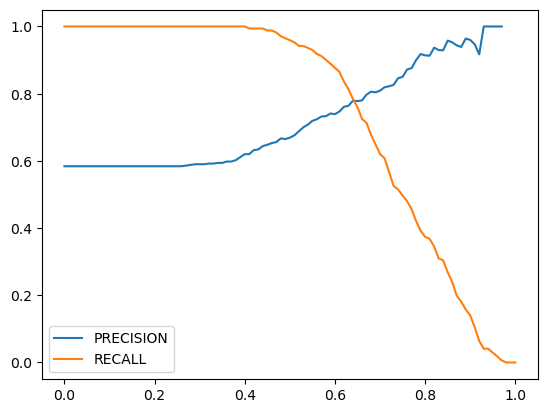

In [90]:
import matplotlib.pyplot as plt
plt.plot(df_scores.threshold, df_scores['precision'], label= 'PRECISION')
plt.plot(df_scores.threshold, df_scores['recall'], label= 'RECALL')
plt.legend()

Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F 1 = 2 ⋅ (P ⋅ R / P + R)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

    0.14
    0.34
    0.54
    0.74


In [91]:
df_scores['f1'] = 2*(df_scores.precision*df_scores.recall/(df_scores.precision + df_scores.recall)).round(3)
    

In [92]:
df_scores.loc[df_scores.f1 == df_scores['f1'].max()]

,threshold,tp,fp,fn,tn,precision,recall,f1
55,0.55,159,62,12,60,0.719,0.930,0.812
57,0.57,156,57,15,65,0.732,0.912,0.812


Question 5: 5-Fold CV

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)

    Iterate over different folds of df_full_train
    Split the data into train and validation
    Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

    0.0001
    0.006
    0.06
    0.36


In [93]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm


for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits= 5, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dicts = df_train.to_dict(orient='records')

        dv = DictVectorizer(sparse= True)
        X_train = dv.fit_transform(dicts)

        model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
        model.fit(X_train, y_train)
        model.fit(X_train, y_train)

        val_dict = df_val.to_dict(orient='records')
        X_val = dv.transform(val_dict)
        y_pred = model.predict_proba(X_val)[:, 1]

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))


  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.876 +- 0.032
C=0.01 0.876 +- 0.032
C=0.1 0.876 +- 0.032
C=0.5 0.876 +- 0.032
C=1 0.876 +- 0.032
C=5 0.876 +- 0.032
C=10 0.876 +- 0.032
